## Prepare Dataset

In [1]:
import kagglehub
import shutil
from pathlib import Path
import json

# Download latest version
path = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")

print("Path to dataset files:", path)

dest = Path("./data/bone-break")  # your project path
dest.mkdir(parents=True, exist_ok=True)
for item in Path(path).iterdir():
    tgt = dest / item.name
    if item.is_dir():
        shutil.copytree(item, tgt, dirs_exist_ok=True)
    else:
        shutil.copy2(item, tgt)
print("Copied to:", dest)

# === Point this to the folder that CONTAINS all class folders ===
CWD = Path.cwd()  # '/content' in Colab
ROOT = CWD / "data" / "bone-break" / "Bone Break Classification" / "Bone Break Classification"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}

def has_images(p: Path) -> bool:
    if not p.exists() or not p.is_dir():
        return False
    for q in p.rglob("*"):
        if q.is_file() and q.suffix.lower() in IMG_EXTS:
            return True
    return False

def derive_class_dirs(root: Path):
    """
    Return a sorted list of (class_name, class_dir) pairs.
    class_dir is the top-level folder representing the class.
    """
    class_pairs = []
    for child in sorted([d for d in root.iterdir() if d.is_dir()], key=lambda x: x.name.lower()):
        # Case 1: images are directly inside the child directory
        if has_images(child):
            class_pairs.append((child.name, child))
            continue

        # Case 2: images live under a Train/train folder inside the child
        train_dir = None
        for name in ("Train", "train"):
            cand = child / name
            if cand.is_dir() and has_images(cand):
                train_dir = cand
                break
        if train_dir is not None:
            class_pairs.append((child.name, child))

    # sanity check
    if not class_pairs:
        raise RuntimeError(f"No class folders with images found under: {root.resolve()}")

    return class_pairs

# ---- Run & summarize ----
class_dirs = derive_class_dirs(ROOT)
class_names = [name for name, _ in class_dirs]
class_to_idx = {name: i for i, name in enumerate(class_names)}

print("Discovered classes:")
for i, name in enumerate(class_names):
    print(f"[{i}] {name}")

# Optional: save mapping for later use
OUT = ROOT / "class_to_idx.json"
with OUT.open("w") as f:
    json.dump(class_to_idx, f, indent=2)
print(f"\nSaved class_to_idx to: {OUT}")

classes = sorted(class_names)

100%|██████████| 28.4M/28.4M [00:00<00:00, 109MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/bone-break-classification-image-dataset/versions/4
Copied to: data/bone-break
Discovered classes:
[0] Avulsion fracture
[1] Comminuted fracture
[2] Fracture Dislocation
[3] Greenstick fracture
[4] Hairline Fracture
[5] Impacted fracture
[6] Longitudinal fracture
[7] Oblique fracture
[8] Pathological fracture
[9] Spiral Fracture

Saved class_to_idx to: /content/data/bone-break/Bone Break Classification/Bone Break Classification/class_to_idx.json


## Train ViT fracture classifier

In [72]:
# ==== 0) Imports ====
import random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from PIL import Image
import timm  # pip install timm if needed
from sklearn.model_selection import StratifiedShuffleSplit

from timm.data import resolve_model_data_config
from timm.data.transforms_factory import create_transform
from pathlib import Path
import random
import numpy as np
from torch.utils.data import WeightedRandomSampler

# ---------- 1) Paths ----------
CWD = Path.cwd()  # '/content' in Colab
DATA_ROOT = CWD / "data" / "bone-break" / "Bone Break Classification" / "Bone Break Classification"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}

def has_images(root: Path) -> bool:
    return any(p.suffix.lower() in IMG_EXTS for p in root.rglob("*") if p.is_file())

class_dirs = [d for d in DATA_ROOT.iterdir() if d.is_dir() and has_images(d)]
classes = sorted(d.name for d in class_dirs)
num_classes = len(classes)

print("num_classes:", num_classes)
print("classes:", classes)

# ---------- 2) Repro ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 3) Transforms (with small geometric jitter) ----------
IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# ---------- 4) Train/Val dataset & stratified split ----------
# Exclude 'Test' images from train/val
def is_trainval_file(path: str) -> bool:
    p = Path(path)
    parts = [s.lower() for s in p.parts]
    return (
        p.suffix.lower() in IMG_EXTS
        and "test" not in parts   # anything under .../<class>/Test/ is excluded
    )

full_ds = datasets.ImageFolder(
    root=str(DATA_ROOT),
    transform=train_tf,
    is_valid_file=is_trainval_file,
)

y = [full_ds.samples[i][1] for i in range(len(full_ds))]  # class indices

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(range(len(full_ds)), y))

train_ds = Subset(full_ds, train_idx)

# 1) Get labels for the train split (NOT the indices)
train_targets = [y[i] for i in train_idx]  # each is a class index

# 2) Count how many samples per class in the train split
class_counts = Counter(train_targets)
print("Train class counts:", class_counts)

# 3) Define per-class weights (inverse frequency)
class_weights = {c: 1.0 / count for c, count in class_counts.items()}

# 4) Define per-sample weights according to its class label
sample_weights = [class_weights[label] for label in train_targets]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # one epoch ≈ size of train set
    replacement=True,
)

# use a separate ImageFolder with val_tf so val images don't get train-time aug
val_base = datasets.ImageFolder(
    root=str(DATA_ROOT),
    transform=val_tf,
    is_valid_file=is_trainval_file,
)
val_ds = Subset(val_base, val_idx)

train_loader = DataLoader(
    train_ds, batch_size=32, sampler=sampler, #shuffle=True,
    num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    num_workers=2, pin_memory=True
)

# ---------- 5) Test dataset & loader ----------
def is_test_file(path: str) -> bool:
    p = Path(path)
    parts = [s.lower() for s in p.parts]
    return (
        p.suffix.lower() in IMG_EXTS
        and "test" in parts       # only files inside .../<class>/Test/...
    )

test_tf = val_tf  # same transforms as validation

test_ds = datasets.ImageFolder(
    root=str(DATA_ROOT),
    transform=test_tf,
    is_valid_file=is_test_file,
)

if len(test_ds) == 0:
    raise RuntimeError(
        f"No test images found. Expected images under '<class>/Test/'. "
        f"Checked under: {DATA_ROOT}"
    )

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False,
    num_workers=2, pin_memory=True
)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# ==== 4) Create ViT model ====

num_classes = len(class_to_idx)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,  # replace classifier head
)

model.to(device)

for name, p in model.named_parameters():
    if "head" not in name:   # for ViT in timm, classifier is usually "head"
        p.requires_grad = False

# Sanity check: how many params are trainable?
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable params:", trainable)

# Optimizer only on head params, higher LR, no weight decay at first
head_params = [p for p in model.parameters() if p.requires_grad]

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    head_params,
    lr=1e-3,
    weight_decay=1e-2,   # was 0.0
)

# ==== 5) Training + validation loop ====

def run_epoch(model, loader, optimizer=None, device="cpu"):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            logits = model(imgs)
            loss = criterion(logits, labels)

            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


EPOCHS = 20
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc     = run_epoch(model, val_loader, optimizer=None, device=device)
    scheduler.step()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
    )


# ==== 6) Optional: quick test-set evaluation ====

test_loss, test_acc = run_epoch(model, test_loader, optimizer=None, device=device)
print(f"\nTest   | loss={test_loss:.4f}, acc={test_acc:.3f}")

num_classes: 10
classes: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Train class counts: Counter({2: 110, 1: 107, 8: 93, 0: 87, 3: 85, 4: 81, 5: 60, 9: 59, 7: 55, 6: 54})
Train: 791, Val: 198, Test: 140
Using device: cuda
Trainable params: 7690
Epoch 01 | train_loss=2.3444, train_acc=0.167 | val_loss=2.2710, val_acc=0.162
Epoch 02 | train_loss=2.1044, train_acc=0.265 | val_loss=2.1700, val_acc=0.232
Epoch 03 | train_loss=2.0315, train_acc=0.290 | val_loss=2.1666, val_acc=0.247
Epoch 04 | train_loss=1.9144, train_acc=0.317 | val_loss=2.1692, val_acc=0.253
Epoch 05 | train_loss=1.8515, train_acc=0.355 | val_loss=2.1081, val_acc=0.288
Epoch 06 | train_loss=1.8154, train_acc=0.367 | val_loss=2.0810, val_acc=0.263
Epoch 07 | train_loss=1.7387, train_acc=0.383 | val_loss=2.1112, val_acc=0.278
Epoch 08 | train_loss=1

In [73]:
# 1) Freeze everything first
for p in model.parameters():
    p.requires_grad = False

# 2) Unfreeze head
for p in model.head.parameters():
    p.requires_grad = True

# 3) Unfreeze last block + final norm
for p in model.blocks[-1].parameters():
    p.requires_grad = True
for p in model.norm.parameters():
    p.requires_grad = True

# 4) Build param groups
head_params = [p for p in model.head.parameters() if p.requires_grad]
last_block_params = list(model.blocks[-1].parameters()) + list(model.norm.parameters())

optimizer = torch.optim.AdamW(
    [
        {"params": head_params,         "lr": 1e-3},  # more aggressive
        {"params": last_block_params,   "lr": 1e-4},  # gentle finetune
    ],
    weight_decay=1e-2,
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

EPOCHS = 20
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc     = run_epoch(model, val_loader, optimizer=None, device=device)
    scheduler.step()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
    )

test_loss, test_acc = run_epoch(model, test_loader, optimizer=None, device=device)
print(f"\nTest   | loss={test_loss:.4f}, acc={test_acc:.3f}")

Epoch 01 | train_loss=1.8922, train_acc=0.388 | val_loss=2.1396, val_acc=0.308
Epoch 02 | train_loss=1.8486, train_acc=0.396 | val_loss=1.9577, val_acc=0.394
Epoch 03 | train_loss=1.7427, train_acc=0.463 | val_loss=2.0322, val_acc=0.348
Epoch 04 | train_loss=1.6322, train_acc=0.544 | val_loss=2.2280, val_acc=0.313
Epoch 05 | train_loss=1.6986, train_acc=0.502 | val_loss=2.0766, val_acc=0.359
Epoch 06 | train_loss=1.6009, train_acc=0.518 | val_loss=2.2085, val_acc=0.318
Epoch 07 | train_loss=1.6251, train_acc=0.531 | val_loss=2.0374, val_acc=0.379
Epoch 08 | train_loss=1.5238, train_acc=0.585 | val_loss=2.1526, val_acc=0.359
Epoch 09 | train_loss=1.5534, train_acc=0.549 | val_loss=2.1381, val_acc=0.354
Epoch 10 | train_loss=1.4503, train_acc=0.598 | val_loss=2.1448, val_acc=0.364
Epoch 11 | train_loss=1.4392, train_acc=0.604 | val_loss=2.2269, val_acc=0.374
Epoch 12 | train_loss=1.4889, train_acc=0.604 | val_loss=2.2298, val_acc=0.333
Epoch 13 | train_loss=1.3952, train_acc=0.619 | val_

## Apply PH-Reg on top (post-hoc registers)

In [74]:
# ==== 7) Post-hoc Register Distillation (PH-Reg-style) ====
import copy
import torch.nn.functional as F

# We assume:
# - `model` is your trained timm ViT: vit_base_patch16_224
# - `train_loader` yields (img, label); labels are ignored here.
# - Images are already resized & normalized as in your earlier code.


# ---- 7.1 Helper: forward through ViT and return ALL tokens (cls + patch) ----

@torch.no_grad()
def vit_forward_tokens(vit: nn.Module, x: torch.Tensor) -> torch.Tensor:
    """
    Forward pass that mimics timm's VisionTransformer.forward_features,
    but returns all tokens [CLS + patches], shape [B, 1+N, D].
    """
    vit.eval()
    B = x.shape[0]

    # Standard ViT pipeline
    x = vit.patch_embed(x)                       # [B, N, D]
    cls_tokens = vit.cls_token.expand(B, -1, -1) # [B, 1, D]
    x = torch.cat((cls_tokens, x), dim=1)        # [B, 1+N, D]
    x = x + vit.pos_embed
    x = vit.pos_drop(x)

    for blk in vit.blocks:
        x = blk(x)

    x = vit.norm(x)                              # [B, 1+N, D]
    return x


# ---- 7.2 Student ViT with K register tokens per block ----

class ViTWithRegisters(nn.Module):
    def __init__(self, base_vit: nn.Module, num_registers: int = 4):
        """
        Wraps a timm VisionTransformer and injects K learnable register tokens
        at each layer, following PH-Reg spirit.

        base_vit: a VisionTransformer instance (e.g., vit_base_patch16_224).
        """
        super().__init__()
        self.vit = base_vit
        self.num_registers = num_registers

        # Embedding dim = D
        embed_dim = self.vit.pos_embed.shape[-1]

        # Single set of K register tokens, shared across layers
        self.register_tokens = nn.Parameter(
            torch.zeros(1, num_registers, embed_dim)
        )
        nn.init.trunc_normal_(self.register_tokens, std=0.02)

        # Keep the classification head as-is for later use
        self.head = self.vit.head
        # We'll treat vit.head as identity and use self.head explicitly
        self.vit.head = nn.Identity()

    def forward_tokens(self, x: torch.Tensor) -> torch.Tensor:
        """
        Return tokens after final norm, shape [B, 1+N, D].
        Registers are injected per block but removed before output.
        """
        B = x.shape[0]
        x = self.vit.patch_embed(x)                         # [B, N, D]
        cls_tokens = self.vit.cls_token.expand(B, -1, -1)   # [B, 1, D]
        x = torch.cat((cls_tokens, x), dim=1)               # [B, 1+N, D]
        x = x + self.vit.pos_embed
        x = self.vit.pos_drop(x)

        for blk in self.vit.blocks:
            # Inject K register tokens
            regs = self.register_tokens.expand(B, -1, -1)   # [B, K, D]
            x = torch.cat([x, regs], dim=1)                 # [B, 1+N+K, D]
            x = blk(x)                                      # block sees regs
            # Remove registers before next layer
            x = x[:, :-self.num_registers, :]               # back to [B, 1+N, D]

        x = self.vit.norm(x)                                # [B, 1+N, D]
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Classification forward: use CLS token + head (if you want to use it).
        """
        tokens = self.forward_tokens(x)                     # [B, 1+N, D]
        cls = tokens[:, 0]                                  # [B, D]
        logits = self.head(cls)
        return logits


# ---- 7.3 Build Teacher (frozen) and Student (register-augmented) ----

# Teacher: frozen copy of your trained ViT (no registers)
teacher_vit = copy.deepcopy(model).to(device)
teacher_vit.eval()
for p in teacher_vit.parameters():
    p.requires_grad = False

# Student: copy of ViT + K register tokens
K_REG = 4  # number of registers; you can try 4, 8, 16, etc.
student_base = copy.deepcopy(model)  # start from same weights
student = ViTWithRegisters(student_base, num_registers=K_REG).to(device)

# Freeze all student params first…
for p in student.parameters():
    p.requires_grad = False

# …then unfreeze ONLY registers + last block + final norm (small subset)
student.register_tokens.requires_grad = True

for p in student.vit.blocks[-1].parameters():
    p.requires_grad = True
for p in student.vit.norm.parameters():
    p.requires_grad = True

# (Optionally, you can also unfreeze self.head if you want to co-train classifier)
# for p in student.head.parameters():
#     p.requires_grad = True

print("Trainable parameters in student:")
trainable = [n for n, p in student.named_parameters() if p.requires_grad]
print(trainable)

optimizer_distill = torch.optim.AdamW(
    [p for p in student.parameters() if p.requires_grad],
    lr=1e-4,
    weight_decay=1e-4,
)


# ---- 7.4 Simple TTA: identity + horizontal flip on tensors ----

def tta_identity(x: torch.Tensor) -> torch.Tensor:
    return x

def tta_hflip(x: torch.Tensor) -> torch.Tensor:
    # flip along width dimension (NCHW -> dim=-1)
    return torch.flip(x, dims=[-1])

TTA_FUNCS = [tta_identity, tta_hflip]


# ---- 7.5 Distillation loop (unlabeled) ----

def distill_epoch(student, teacher, loader, optimizer, device="cuda"):
    student.train()
    teacher.eval()

    total_loss = 0.0
    total_batches = 0

    for imgs, _ in loader:  # labels unused
        imgs = imgs.to(device, non_blocking=True)

        # 1) Teacher: compute denoised patch targets via TTA averaging
        with torch.no_grad():
            teacher_feats_list = []
            for tta in TTA_FUNCS:
                x_aug = tta(imgs)
                tokens_t = vit_forward_tokens(teacher, x_aug)    # [B, 1+N, D]
                patches_t = tokens_t[:, 1:, :]                   # drop CLS
                teacher_feats_list.append(patches_t)

            # [n_tta, B, N, D] -> [B, N, D]
            teacher_patches = torch.stack(teacher_feats_list, dim=0).mean(dim=0)

        # 2) Student: get patch tokens for original (non-augmented) image
        tokens_s = student.forward_tokens(imgs)   # [B, 1+N, D]
        student_patches = tokens_s[:, 1:, :]      # [B, N, D]

        # 3) Distillation losses: MSE + cosine
        # Make sure shapes match: [B, N, D]
        assert student_patches.shape == teacher_patches.shape

        mse_loss = F.mse_loss(student_patches, teacher_patches)

        # cosine_similarity: [B, N]
        cos_sim = F.cosine_similarity(student_patches, teacher_patches, dim=-1)
        cos_loss = 1.0 - cos_sim.mean()

        loss = mse_loss + cos_loss

        # 4) Backprop on student only
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    return total_loss / max(total_batches, 1)


DISTILL_EPOCHS = 5  # start small; you can increase

for epoch in range(1, DISTILL_EPOCHS + 1):
    avg_loss = distill_epoch(student, teacher_vit, train_loader, optimizer_distill, device=device)
    print(f"[Distill] Epoch {epoch:02d} | loss={avg_loss:.4f}")

print("Finished post-hoc register distillation.")


Trainable parameters in student:
['register_tokens', 'vit.blocks.11.norm1.weight', 'vit.blocks.11.norm1.bias', 'vit.blocks.11.attn.qkv.weight', 'vit.blocks.11.attn.qkv.bias', 'vit.blocks.11.attn.proj.weight', 'vit.blocks.11.attn.proj.bias', 'vit.blocks.11.norm2.weight', 'vit.blocks.11.norm2.bias', 'vit.blocks.11.mlp.fc1.weight', 'vit.blocks.11.mlp.fc1.bias', 'vit.blocks.11.mlp.fc2.weight', 'vit.blocks.11.mlp.fc2.bias', 'vit.norm.weight', 'vit.norm.bias']
[Distill] Epoch 01 | loss=2.1330
[Distill] Epoch 02 | loss=1.3219
[Distill] Epoch 03 | loss=1.1261
[Distill] Epoch 04 | loss=1.0661
[Distill] Epoch 05 | loss=1.0303
Finished post-hoc register distillation.


In [75]:
from collections import Counter

student.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = student(imgs)
        preds = logits.argmax(dim=1).cpu()

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

pred_counts = Counter(all_preds)
true_counts = Counter(all_labels)

print("Pred counts:", pred_counts)
print("True counts:", true_counts)


Pred counts: Counter({0: 33, 3: 22, 9: 22, 8: 18, 5: 12, 1: 10, 6: 8, 4: 7, 2: 6, 7: 2})
True counts: Counter({2: 19, 8: 18, 3: 16, 7: 16, 0: 14, 1: 14, 6: 12, 9: 12, 4: 10, 5: 9})


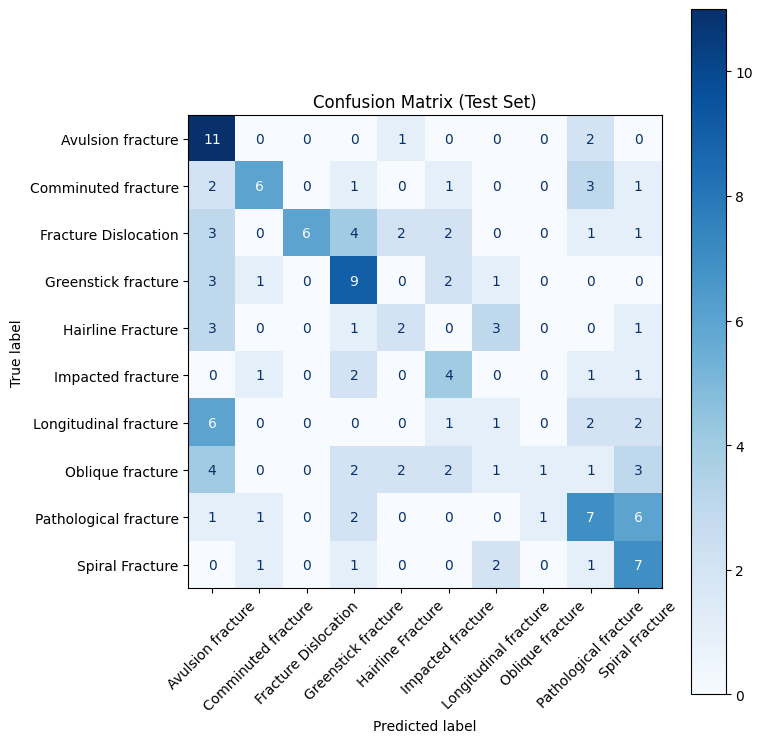

In [76]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have:
# - test_loader
# - device
# - classes (list of class names, length = num_classes)

def confusion_matrix_for_model(model, loader, classes, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            preds = logits.argmax(dim=1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(classes))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

    return cm

# Example: for your PH-Reg student
cm_student = confusion_matrix_for_model(student, test_loader, classes, device)

# Or for the base ViT model
# cm_base = confusion_matrix_for_model(model, test_loader, classes, device)

## LeGrad explainer on top of PH-Reg student

In [77]:
# # ==== 8) LeGrad-style explanation on the PH-Reg student ====
# import math
# import torch.nn.functional as F
# import matplotlib.pyplot as plt


# class LeGradExplainer:
#     """
#     Simple LeGrad-style explainer for timm ViT (here: your PH-Reg student).

#     - Hooks attention maps from each block (student.vit.blocks[i].attn.attn_drop).
#     - During backward, collects gradients w.r.t. those attention maps.
#     - Grad-weighted aggregation across heads and layers to get importance per patch.
#     """

#     def __init__(self, student_model, device, img_size=224):
#         self.model = student_model
#         self.device = device
#         self.img_size = img_size

#         # Infer patch grid size from patch_embed
#         num_patches = self.model.vit.patch_embed.num_patches  # e.g. 14*14
#         self.grid_size = int(math.sqrt(num_patches))
#         assert self.grid_size * self.grid_size == num_patches, \
#             f"num_patches={num_patches} is not a perfect square"

#     def _register_hooks(self):
#         self.attn_maps = []
#         self.attn_grads = []
#         self.handles = []

#         def make_hook():
#             def hook(module, input, output):
#                 # output: attention after dropout, shape [B, H, T, T]
#                 print(f"[HOOK] forward attn from block, shape = {output.shape}")
#                 self.attn_maps.append(output)
#                 # register hook to capture gradient w.r.t. this attention
#                 def grad_hook(grad):
#                     print(f"[HOOK] grad attn from block, shape = {grad.shape}")
#                     self.attn_grads.append(grad)
#                 output.register_hook(grad_hook)
#             return hook

#         # Attach a hook to each block's attention dropout
#         for blk in self.model.vit.blocks:
#             # h = blk.attn.attn_drop.register_forward_hook(make_hook(i))
#             h = blk.attn.register_forward_hook(make_hook())
#             self.handles.append(h)
#         print(f"[DEBUG] Registered {len(self.handles)} attention hooks")

#     def _remove_hooks(self):
#         for h in self.handles:
#             h.remove()
#         self.handles = []

#     def generate(self, img, target_class=None):
#         """
#         img: tensor [1, 3, H, W] (already normalized like training)
#         target_class: int or tensor [1]; if None, use model prediction.
#         Returns:
#             heatmap: [H, W] tensor in [0, 1]
#         """
#         self.model.eval()
#         img = img.to(self.device)

#         # 1) Register hooks on attention modules
#         self._register_hooks()

#         # 2) Forward + backward on target class
#         self.model.zero_grad()
#         logits = self.model(img)  # [1, num_classes]

#         if target_class is None:
#             target_class = logits.argmax(dim=1)  # [1]
#         elif isinstance(target_class, int):
#             target_class = torch.tensor([target_class], device=self.device)

#         # Create one-hot for target logit and backprop
#         one_hot = torch.zeros_like(logits)
#         one_hot[0, target_class.item()] = 1.0
#         (logits * one_hot).sum().backward()

#         # 3) Build LeGrad map: grad-weighted attention, aggregated across layers
#         # We assume batch size = 1 here for explainability
#         assert len(self.attn_maps) == len(self.attn_grads), "Mismatch in attn vs grad lists"

#         per_layer_maps = []  # list of [N] tensors (N = num_patches)

#         for attn, grad in zip(self.attn_maps, self.attn_grads):
#             # attn, grad: [B, heads, T, T]
#             B, H, T, _ = attn.shape
#             assert B == 1, "LeGradExplainer currently assumes batch_size=1"

#             # We want importance of image patches w.r.t. CLS token query.
#             # CLS token = index 0, image patches = 1..T-1.
#             # Grad-weighted attention (like CAM in attention space).
#             attn_cls = attn[:, :, 0, 1:]   # [1, H, N]
#             grad_cls = grad[:, :, 0, 1:]   # [1, H, N]

#             # Grad * attention, ReLU, average over heads
#             cam = (attn_cls * grad_cls).clamp(min=0).mean(dim=1)  # [1, N]
#             per_layer_maps.append(cam.squeeze(0))                 # [N]

#         # 4) Aggregate across layers
#         # [L, N] -> [N]
#         legrad_tokens = torch.stack(per_layer_maps, dim=0).mean(dim=0)  # [N]

#         # Normalize over patches
#         legrad_tokens = legrad_tokens - legrad_tokens.min()
#         if legrad_tokens.max() > 0:
#             legrad_tokens = legrad_tokens / legrad_tokens.max()

#         # 5) Reshape to patch grid and upsample to image resolution
#         N = legrad_tokens.numel()
#         assert N == self.grid_size * self.grid_size, "Token count != grid_size^2"

#         grid = legrad_tokens.view(1, 1, self.grid_size, self.grid_size)  # [1,1,h,w]
#         heatmap = F.interpolate(
#             grid, size=(self.img_size, self.img_size),
#             mode="bilinear", align_corners=False
#         ).squeeze(0).squeeze(0)  # [H, W]

#         # Normalize again to [0, 1] for visualization
#         heatmap = heatmap - heatmap.min()
#         if heatmap.max() > 0:
#             heatmap = heatmap / heatmap.max()

#         # 6) Clean up hooks
#         self._remove_hooks()

#         return heatmap.detach().cpu()

In [78]:
# explainer = LeGradExplainer(student, device=device, img_size=IMG_SIZE)

In [79]:
# # Take one sample from val set
# imgs, labels = next(iter(test_loader))
# img = imgs[0:1]          # [1, 3, H, W]
# label = labels[0].item()

# # Option A: explain the predicted class
# student.eval()
# with torch.no_grad():
#     logits = student(img.to(device))
# pred_class = logits.argmax(dim=1).item()
# print(f"True label: {label}, Predicted: {pred_class}")

# # Generate LeGrad heatmap for predicted class
# heatmap = explainer.generate(img, target_class=pred_class)  # [H, W]

# # Visualize overlay
# # (if your images are normalized, we roughly unnormalize for display)
# mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
# std  = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
# img_vis = img[0].cpu() * std + mean
# img_vis = img_vis.clamp(0, 1).permute(1, 2, 0)  # [H, W, 3]

# plt.figure(figsize=(6, 6))
# plt.imshow(img_vis)
# plt.imshow(heatmap, cmap="jet", alpha=0.4)  # overlay LeGrad
# plt.axis("off")
# plt.title(f"LeGrad (pred class = {pred_class})")
# plt.show()

In [83]:
def remove_all_hooks(module):
    # Walks every submodule and clears all hook dicts
    for m in module.modules():
        # Forward hooks
        if hasattr(m, "_forward_hooks"):
            m._forward_hooks.clear()
        if hasattr(m, "_forward_pre_hooks"):
            m._forward_pre_hooks.clear()
        # Backward hooks
        if hasattr(m, "_backward_hooks"):
            m._backward_hooks.clear()

# Apply to your PH-Reg student
remove_all_hooks(student)
print("Cleared all hooks on student.")

Cleared all hooks on student.


In [84]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


class TokenGradExplainer:
    """
    LeGrad-style token gradient explainer for your PH-Reg student:
    - Hooks each transformer block's output tokens.
    - Collects outputs + gradients.
    - Uses grad * activation over patch tokens, aggregated across layers,
      to produce a per-patch importance map.
    """

    def __init__(self, student_model, device, img_size=224, num_registers=4):
        self.model = student_model
        self.device = device
        self.img_size = img_size
        self.num_registers = num_registers

        # Infer patch grid size from patch_embed
        num_patches = self.model.vit.patch_embed.num_patches  # e.g. 14*14
        self.grid_size = int(math.sqrt(num_patches))
        assert self.grid_size * self.grid_size == num_patches, \
            f"num_patches={num_patches} is not a perfect square"

    def _register_hooks(self):
        self.block_outs = []
        self.block_grads = []
        self.handles = []

        def make_hook(idx):
            def hook(module, input, output):
                # output: tokens from this block, shape [B, T, D]
                self.block_outs.append(output)

                def grad_hook(grad):
                    self.block_grads.append(grad)

                output.register_hook(grad_hook)
            return hook

        # Hook on each transformer block output
        for i, blk in enumerate(self.model.vit.blocks):
            h = blk.register_forward_hook(make_hook(i))
            self.handles.append(h)

    def _remove_hooks(self):
        for h in self.handles:
            h.remove()
        self.handles = []

    def generate(self, img, target_class=None):
        """
        img: tensor [1, 3, H, W] (normalized like training).
        target_class: int or None.
          - If None, uses the model's predicted class.
        Returns:
            heatmap: [H, W] tensor in [0, 1].
        """
        self.model.eval()
        img = img.to(self.device)

        # 1) Register hooks
        self._register_hooks()

        # 2) Forward + backward
        self.model.zero_grad()
        logits = self.model(img)  # [1, num_classes]

        if target_class is None:
            target_class = logits.argmax(dim=1)
        elif isinstance(target_class, int):
            target_class = torch.tensor([target_class], device=self.device)

        one_hot = torch.zeros_like(logits)
        one_hot[0, target_class.item()] = 1.0
        (logits * one_hot).sum().backward()

        # 3) Build per-layer patch importance maps
        assert len(self.block_outs) == len(self.block_grads), \
            "Mismatch in block_outs vs block_grads"

        per_layer_maps = []
        N = self.grid_size * self.grid_size  # number of patches

        for out, grad in zip(self.block_outs, self.block_grads):
            # out, grad: [B, T, D], T = 1 + N (+ K registers inside block)
            B, T, D = out.shape
            assert B == 1, "Explainer currently assumes batch_size=1"

            # Tokens layout in your student:
            # - CLS at index 0
            # - N image patches at indices [1 .. 1+N-1]
            # (register tokens are appended inside blocks then removed before next layer)
            patch_out  = out[:, 1:1+N, :]    # [1, N, D]
            patch_grad = grad[:, 1:1+N, :]   # [1, N, D]

            # Grad * activation, ReLU, average over hidden dim
            cam = (patch_out * patch_grad).clamp(min=0).mean(dim=-1)  # [1, N]
            per_layer_maps.append(cam.squeeze(0))  # [N]

        if not per_layer_maps:
            self._remove_hooks()
            raise RuntimeError("No block outputs were captured; hooks did not fire.")

        # 4) Aggregate across layers: [L, N] -> [N]
        token_importance = torch.stack(per_layer_maps, dim=0).mean(dim=0)  # [N]

        # Normalize over patches
        token_importance = token_importance - token_importance.min()
        if token_importance.max() > 0:
            token_importance = token_importance / token_importance.max()

        # 5) Reshape to patch grid + upsample to image resolution
        grid = token_importance.view(1, 1, self.grid_size, self.grid_size)  # [1,1,h,w]
        heatmap = F.interpolate(
            grid,
            size=(self.img_size, self.img_size),
            mode="bilinear",
            align_corners=False,
        ).squeeze(0).squeeze(0)  # [H, W]

        # Normalize again to [0, 1]
        heatmap = heatmap - heatmap.min()
        if heatmap.max() > 0:
            heatmap = heatmap / heatmap.max()

        # 6) Clean up
        self._remove_hooks()

        return heatmap.detach().cpu()


True label: 0, Predicted: 0


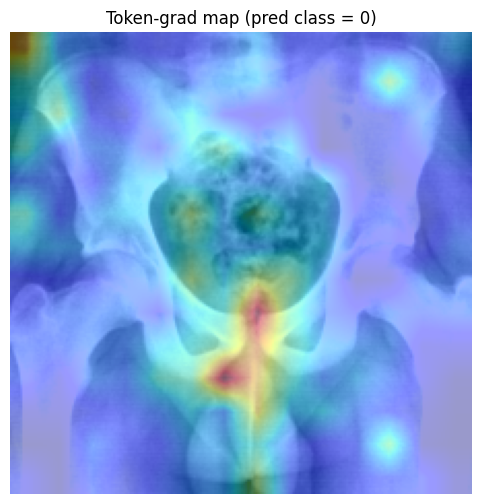

In [86]:
# Instantiate explainer
explainer = TokenGradExplainer(student, device=device, img_size=IMG_SIZE, num_registers=K_REG)

# Take one sample from test set
imgs, labels = next(iter(test_loader))
img = imgs[0:1]          # [1, 3, H, W]
label = labels[0].item()

# Explain predicted class
student.eval()
with torch.no_grad():
    logits = student(img.to(device))
pred_class = logits.argmax(dim=1).item()
print(f"True label: {label}, Predicted: {pred_class}")

heatmap = explainer.generate(img, target_class=pred_class)  # [H, W]

# Visualize overlay
mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
std  = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
img_vis = img[0].cpu() * std + mean
img_vis = img_vis.clamp(0, 1).permute(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.imshow(img_vis)
plt.imshow(heatmap, cmap="jet", alpha=0.4)
plt.axis("off")
plt.title(f"Token-grad map (pred class = {pred_class})")
plt.show()


In [85]:
num_classes = len(class_to_idx)
idx_to_class = {v: k for k, v in class_to_idx.items()}

correct_examples = {c: None for c in range(num_classes)}  # class_idx -> [1,C,H,W]

student.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = student(imgs)
        preds = logits.argmax(dim=1)

        for img, y, yhat in zip(imgs, labels, preds):
            c = int(y.item())
            if correct_examples[c] is None and yhat == y:
                correct_examples[c] = img.unsqueeze(0).cpu()  # store as [1,C,H,W]

        if all(v is not None for v in correct_examples.values()):
            break

for c in range(num_classes):
    print(f"class {c} ({idx_to_class[c]}): example is None? {correct_examples[c] is None}")

class 0 (Avulsion fracture): example is None? False
class 1 (Comminuted fracture): example is None? False
class 2 (Fracture Dislocation): example is None? False
class 3 (Greenstick fracture): example is None? False
class 4 (Hairline Fracture): example is None? False
class 5 (Impacted fracture): example is None? False
class 6 (Longitudinal fracture): example is None? False
class 7 (Oblique fracture): example is None? False
class 8 (Pathological fracture): example is None? False
class 9 (Spiral Fracture): example is None? False


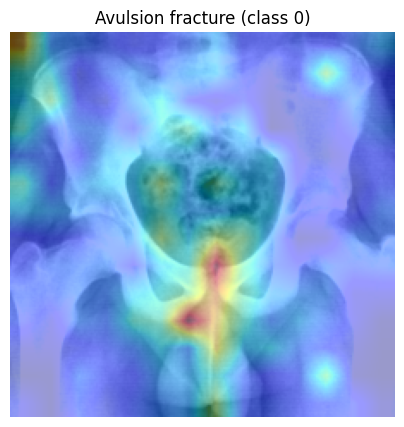

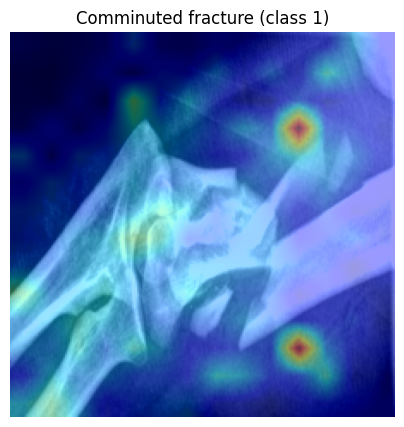

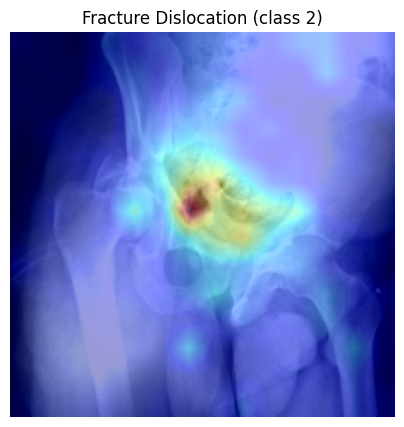

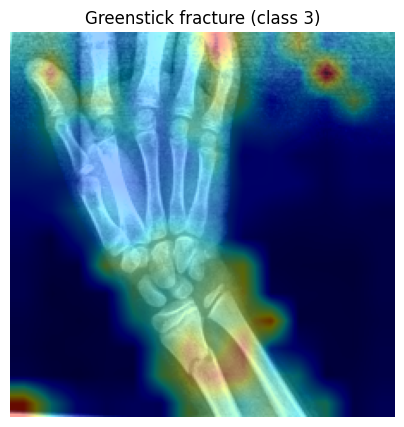

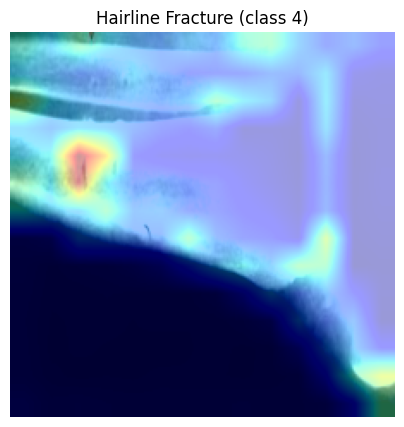

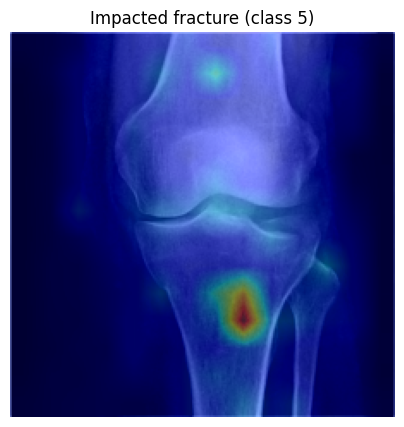

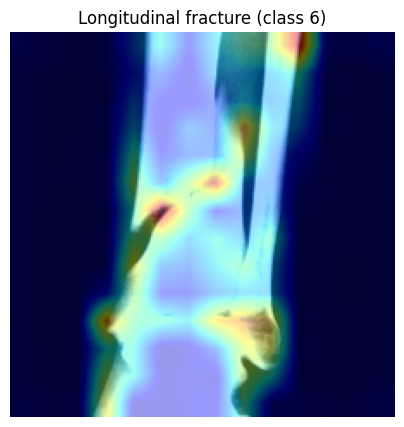

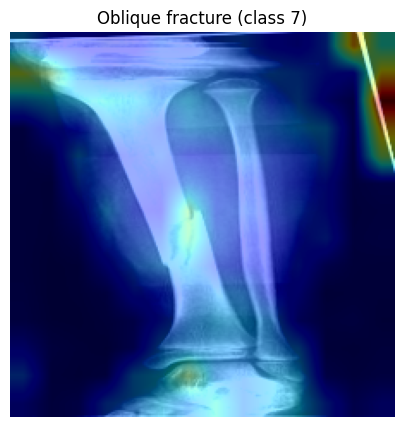

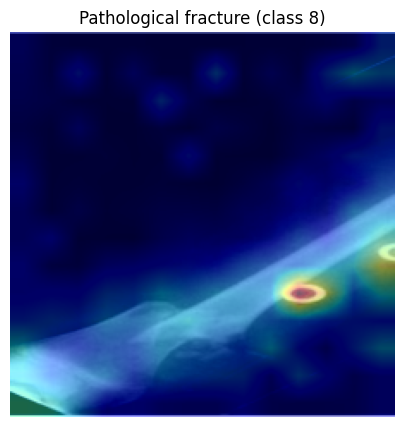

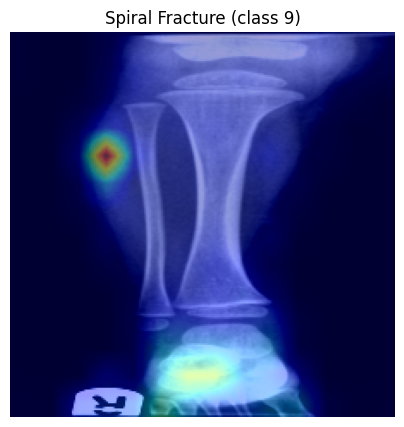

In [87]:
explainer = TokenGradExplainer(student, device=device, img_size=IMG_SIZE, num_registers=K_REG)
student.eval()

mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
std  = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)

for cls_idx in range(num_classes):
    img = correct_examples[cls_idx]
    cls_name = idx_to_class[cls_idx]

    if img is None:
        print(f"Skipping class {cls_idx} ({cls_name}) – no correct predictions in test set.")
        continue

    # Explain for the **true/predicted** class
    heatmap = explainer.generate(img, target_class=cls_idx)

    # Unnormalize for display
    img_vis = img[0].cpu() * std + mean
    img_vis = img_vis.clamp(0, 1).permute(1, 2, 0)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_vis)
    plt.imshow(heatmap, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title(f"{cls_name} (class {cls_idx})")
    plt.show()

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)